## KUKA Youbot Simulator

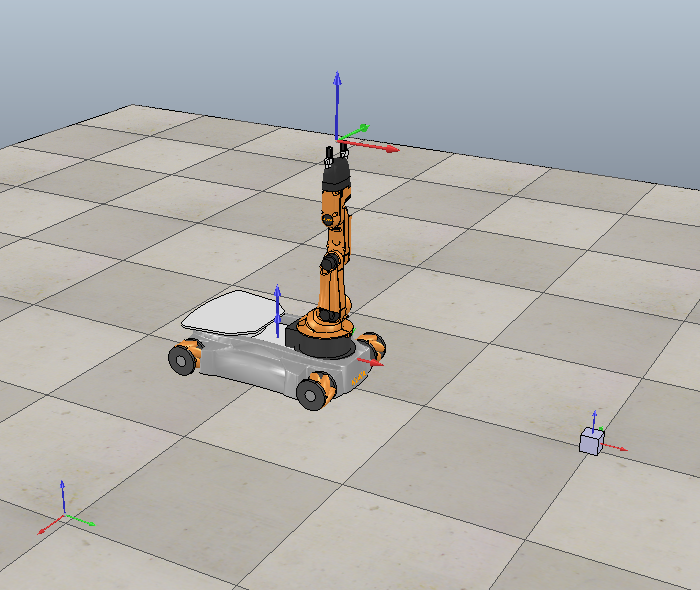

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import KukaYoubotControl as KYC
import Robotics as Robo

### Initialize Robotics Object to get useful functions

In [2]:
robotics = Robo.Robotics()

### Initialize Manipulator Screw Axes

In [3]:
M0E = np.array([[1, 0, 0, 0.033], [0, 1, 0, 0], [0, 0, 1, 0.6546], [0, 0, 0, 1]])  # M0E Matrix
TB0 = np.array([[1, 0, 0, 0.1662], [0, 1, 0, 0], [0, 0, 1, 0.0026], [0, 0, 0, 1]]) # TB0 Matrix
T0B = robotics.inverse_T_Matrix(TB0)

### Screw Axis
B1 = np.array([0, 0, 1, 0, 0.033, 0])
B2 = np.array([0, -1, 0, -0.5076, 0, 0])
B3 = np.array([0, -1, 0, -0.3526, 0, 0])
B4 = np.array([0, -1, 0, -0.2176, 0, 0])
B5 = np.array([0, 0, 1, 0, 0, 0])

### Screw List
screw_list = [B1, B2, B3, B4, B5]

### Initialize Configurations of Youbot @ Start Position

#### Configuration between Space Frame and Body Frame

In [4]:
TSB = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0.0963], [0, 0, 0, 1]])

#### Configuration between Space Frame and Manipulator End-Effector Frame

In [5]:
TSE_actual = np.array([[1, 0, 0, 0.1992], [0, 1, 0, 0.0], [0, 0, 1, 0.7535], [0, 0, 0, 1]])

#### Rotation Matrix @ Grasping Position

In [6]:
R_Y = np.array([[np.cos(3*(np.pi/4)), 0, np.sin(3*(np.pi/4))], [0, 1, 0],[-np.sin(3*np.pi/4), 0, np.cos(3*np.pi/4)]])
R_Z = np.array([[np.cos(-np.pi/2), -np.sin(-np.pi/2), 0], [np.sin(-np.pi/2), np.cos(-np.pi/2), 0],  [0, 0, 1]])
R_4 = np.dot(R_Z, R_Y)

#### 5 Configuration Points

In [7]:
TSE_1 = np.array([[1, 0, 0, 0.1992], [0, 1, 0, 0], [0, 0, 1, 0.7535], [0, 0, 0, 1]])

TSE_2 = np.array([[np.cos(3*(np.pi/4)), 0, np.sin(3*(np.pi/4)), 1], [0, 1, 0, 0],
                  [-np.sin(3*np.pi/4), 0, np.cos(3*np.pi/4), 0.075], [0, 0, 0, 1]])

TSE_3 = np.array([[np.cos(3*(np.pi/4)), 0, np.sin(3*(np.pi/4)), 1], [0, 1, 0, 0],  
                  [-np.sin(3*np.pi/4), 0, np.cos(3*np.pi/4), 0.025], [0, 0, 0, 1]])

TSE_4 = np.array([[0, +1, 0, 0], [1, 0, 0, -1], [0, 0, -1, 0.075], [0, 0, 0, 1]])
TSE_4[0:-1, 0:-1] = R_4

TSE_5 = np.array([[0, 1, 0, 0],  [1, 0, 0, -1], [0, 0, -1, 0.01],  [0, 0, 0, 1]])
TSE_5[0:-1, 0:-1] = R_4

### Generate Trajectory

#### Trajectory Parameters

In [8]:
traj_type  = 'S' # Screw Type
time_scale = 'C' # Cubic Time Scaling

#### Trajectory 1

In [9]:
trajectory_1 = KYC.reference_Trajectory(TSE_1, TSE_2, 5, 0.01, traj_type, time_scale)

#### Trajectory 2

In [10]:
trajectory_2 = KYC.reference_Trajectory(TSE_2, TSE_3, 2, 0.01, traj_type, time_scale)

#### Trajectory 3

In [11]:
trajectory_3 = KYC.duplicate_Trajectory(TSE_3, 63)

#### Trajectory 4

In [12]:
trajectory_4 = KYC.reference_Trajectory(TSE_3, TSE_2, 2, 0.01, traj_type, time_scale)

#### Trajectory 5

In [13]:
trajectory_5 = KYC.reference_Trajectory(TSE_2, TSE_4, 5, 0.01, traj_type, time_scale)

#### Trajectory 6

In [14]:
trajectory_6 = KYC.reference_Trajectory(TSE_4, TSE_5, 2, 0.01, traj_type, time_scale)

#### Trajectory 7

In [15]:
trajectory_7 = KYC.duplicate_Trajectory(TSE_5, 63)

#### Trajectory 8

In [16]:
trajectory_8 = KYC.reference_Trajectory(TSE_5, TSE_4, 2, 0.01, traj_type, time_scale)

#### Combine Trajectories

In [17]:
list_trajectory  = [trajectory_1, trajectory_2, trajectory_3, trajectory_4, trajectory_5, trajectory_6, trajectory_7, trajectory_8]
list_gripper_act = [0, 0, 1, 1, 1, 1, 0, 0]

### CombineTrajectory
reference_traj = KYC.combine_Trajectories(list_trajectory, list_gripper_act)

### Simulation Function

In [20]:
def simulate_Youbot(reference_trajectory, TSE_actual=None, TSB=None ):
    """Simulates the Youbot. ===> Type : Free Function.
       Parameters:
       ===========
                  reference_trajectory : A list containing list of SE(3) Configuration and Gripper Actuation; ===> Type : List.
                  TSE_actual  : The actual SE(3) configuration;              ===> Type : Numpy Matrix; Shape : (4, 4).
                  TSB         : The configuration b/w space and chasis body; ===> Type : Numpy Matrix; Shape : (4, 4).
       Return:
       ===========
                  A Matrix of configuration, wheel-joint angles and gripper actuation; ===> Type : Numpy Matrix; Shape : (N, 13).
                  The Twist Error; ===> Type : Numpy Matrix; Shape : (N, 6).
    """
    ### Create a numpy matrix to store the resulta
    data_matrix = np.zeros(shape=(len(reference_trajectory), 13)) # (N, 13)
    twist_error = np.zeros(shape=(len(reference_trajectory), 6)) # (N, 6)
    
    ### Time Step
    dt = 0.01
    
    ### Integration error 
    X_int_error = np.zeros((6, 1)) # Shape : (6, 1)
    
    ### Joint angles
    joint_angles = [0.0, 0.0, 0.0, 0.0, 0.0] # List of length 5
    
    ### Angles of joint and wheels in starting position
    p_angle = np.zeros((9, 1)) # Shape : (9,1)
    
    ### Configuration of the chassis @ starting position and chassis angle
    p_config_q = np.zeros((3, 1)) # Shape : (3, 1)
    p_head_phi = 0.0              # Float
    
    ### TSE Actual Calculation
    T0E = robotics.forward_Kinematics_Body(screw_list, [0, 0, 0, 0, 0], M0E)
    TSE_actual = np.dot(TSB, np.dot(TB0, T0E))
    
    # Loop till the n-1 the element of the reference_trajectory due to TSE_desired_next
    for index, SE_3_config_gripper in enumerate(reference_trajectory[:-1]):  
        
        ### Obtain the desired configuration and TSE_desired_next
        TSE_desired, gripper_act = SE_3_config_gripper         # Destructure the List
        TSE_desired_next = reference_trajectory[index + 1][0]  # Extract TSE_desired_next

        ### Call Control Function to obtain Twist and next time step integration error
        V, X_int_error_, Xerror = KYC.control(TSE_desired, TSE_desired_next, TSE_actual, dt, X_int_error) # Shape : (6, 1)
        twist_error[index+1, :] = Xerror.ravel() # Shape : (6,)
        
        ### Get velocity of the youbot and clip the velocities
        velocities = KYC.velocity_Youbot(V, joint_angles) # Shape : (9, 1)
        
        ### Clip velocities to a certain range
        velocities = np.clip(velocities, a_min=-5, a_max=5) # Shape : (9, 1) 
        
        ### Pass velocities to the integrator
        angles = KYC.integrator(velocities, p_angle, dt)       # Shape : (9, 1)
        
        ### Update the Youbot configuration using odometry
        delta_theta      = np.expand_dims(angles[0:4, 0] - p_angle[0:4, 0], axis=1) # Shape : (4, 1)
        c_config_q, TBB_ = KYC.odometry(delta_theta, p_config_q, p_head_phi)            # Shape : (3, 1) & (4, 4) 
        
        ### Get change in Space-End Effector Configuration due to Movement
        joint_angles = list(angles[4:, 0]) 
        T0E = robotics.forward_Kinematics_Body(screw_list, joint_angles, M0E)
        TSB = np.array([[np.cos(c_config_q[0, 0]), -np.sin(c_config_q[0, 0]), 0, c_config_q[1, 0]],
                        [np.sin(c_config_q[0, 0]), +np.cos(c_config_q[0, 0]), 0, c_config_q[2, 0]],
                        [0, 0, 1, 0.0963],
                        [0, 0, 0, 1]])
        TSE_actual = np.dot(TSB, np.dot(TB0, T0E))
        
        ### Update values to the data frame array
        data_matrix[index+1, 0:3]  = c_config_q[:, 0] # Configuration of chassis
        data_matrix[index+1, 3:8]  = angles[4:, 0]    # Manipulator angles
        data_matrix[index+1, 8:12] = angles[0:4, 0]   # Wheel angles
        data_matrix[index+1, 12]   = gripper_act      # Gripper Actuation
        
        ### Update Values for next iteration
        X_int_error  = X_int_error_        # Update integration error; Shape : (6, 1)
        p_angle      = angles              # Update wheel-joint angles; Shape : (9, 1)
        p_config_q   = c_config_q          # Update Chassis configuration; Shape : (3, 1)
        p_head_phi   = c_config_q[0, 0]    # Update Chassis heading; Type : Float
        
        
    ### Return
    return KYC.near_Zero(data_matrix), twist_error

#### Simulation

In [21]:
data, twist_error = simulate_Youbot(reference_traj, TSE_actual, TSB)

#### Plot Log Error

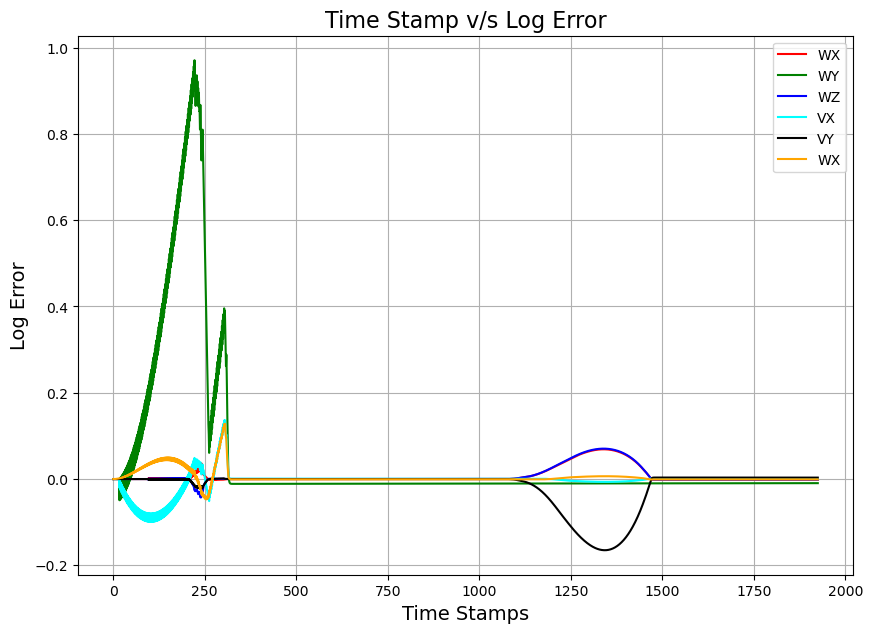

In [22]:
KYC.plot_Twist_Error(twist_error)

#### Convert to CSV

In [23]:
d = pd.DataFrame(data)
d.to_csv('data_0.csv', header=None, index=False)